In [16]:
# default_exp correlation

# Correlation analysis of features selected

In [2b_median_mad_based_sample_and_feature_selection](2b_median_mad_based_sample_and_feature_selection) a number of samples and features were retained for further analysis. In this notebook we examine the correlation between these features.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load common_.py
from common import *

In [4]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
from tqdm.notebook import tqdm

In [5]:
# ONLY LOADING LOW

# samples = pandas.read_csv("data/selected_samples.csv")
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [6]:
df = df[df["meta_label_coi"]]
df.shape

(339045, 113)

In [7]:
with open("data/selected_features_low.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [8]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [9]:
df.shape

(339045, 79)

# Iterative feature elimination

Correlation for all pairwise feature combinations is computed. For each pair, one feature is dropped if the correlation is above a threshold.

In [10]:
df.filter(regex="feat").corr().mean().mean()

0.10592880244028649

In [11]:
#export
def get_correlated_features(df, thresh=0.8):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    
    # loop over all feature combinations
    for i in range(correlation.shape[0]):
        for j in range(i):
            
            # check absolute value of correlation against threshold
            if abs(correlation.iloc[i, j]) > thresh:
                
                # keep feature with most variance
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [12]:
from joblib import Parallel, delayed

In [13]:
thresholds = numpy.linspace(0.5, 0.99, 30)
    
def get_mean_corr(t):
    correlated_features = get_correlated_features(df.filter(regex="feat"), thresh=t)
    correlation = df.drop(columns=correlated_features).corr()
    return correlation.mean().mean()/len(correlation)

mean_corr = Parallel(n_jobs=20)(delayed(get_mean_corr)(t) for t in thresholds)

Text(0.5, 1.0, 'Mean correlation per feature')

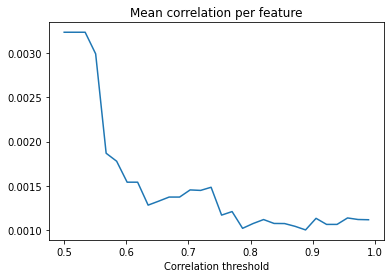

In [14]:
plt.plot(thresholds, mean_corr)
plt.xlabel("Correlation threshold")
plt.title("Mean correlation per feature")

In [15]:
thresholds[numpy.array(mean_corr).argmin()]

0.8886206896551724

In [16]:
correlated_features = get_correlated_features(df.filter(regex="feat"), thresh=thresholds[numpy.array(mean_corr).argmin()])
correlation = df.drop(columns=correlated_features).corr()
correlation.mean().mean()

0.05926765321076954

In [17]:
df.drop(columns=correlated_features).head()

,feat_contrast_m09_bf2,feat_gradient_rms_m01_bf,feat_gradient_rms_m06_ssc,feat_gradient_rms_m07_ch7,feat_gradient_rms_m11_ch11,feat_intensity_mc_ch04,feat_intensity_mc_ssc,feat_width_m09,feat_width_m06,feat_width_m01,...,meta_flow_speed,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,meta_label_mcp_pos_psba_neg,meta_label_mcp_neg_psba_neg,meta_label
8,0.838374,56.374084,40.187954,30.313007,34.165466,-560.492676,3421.808838,5.333333,3.666667,5.333333,...,43.244419,0,R1,Low,True,True,False,False,False,mcp_neg_psba_pos
9,1.389866,55.626270,32.673328,28.120426,32.147324,-1607.611084,144695.734375,6.333333,6.000000,6.333333,...,43.244419,0,R1,Low,True,True,False,False,False,mcp_neg_psba_pos
12,0.588988,54.059586,37.338764,19.192358,15.194324,-968.277771,4338.236328,7.666667,5.000000,6.666667,...,43.244419,0,R1,Low,True,True,False,False,False,mcp_neg_psba_pos
14,0.975258,46.626072,24.215099,21.267845,18.301588,-1138.748047,122928.828125,12.333333,7.333333,12.666667,...,43.220192,0,R1,Low,True,True,False,False,False,mcp_neg_psba_pos
26,0.781494,64.453186,40.857445,30.200451,45.642982,-1243.012207,2674.908447,4.666667,4.333333,5.666667,...,43.268673,0,R1,Low,True,True,False,False,False,mcp_neg_psba_pos


<AxesSubplot:>

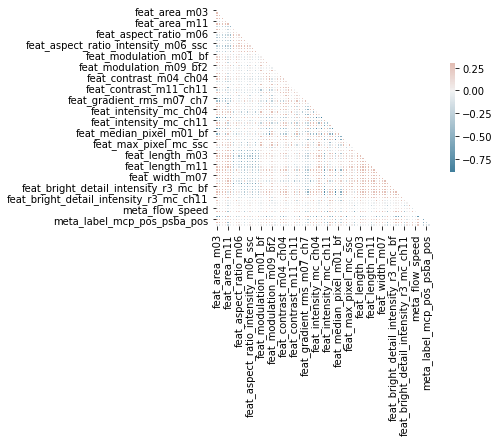

In [53]:
mask = numpy.triu(numpy.ones_like(correlation, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
cmap = seaborn.diverging_palette(230, 20, as_cmap=True)
seaborn.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})